In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/breakhis/Folds.csv
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/process_db_stat.py
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/fibroadenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/phyllodes_tumor.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/tubular_adenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/adenosis.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/README_B.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29

 # **1) Importing needed libraries**

In [2]:
import os
from os import listdir
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
# -----------------------
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
# -----------------------
import tensorflow as tf
from keras import Model
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,InputLayer, Dense, Dropout, Flatten,ELU, PReLU, LeakyReLU,ThresholdedReLU,Reshape,GlobalAveragePooling2D,BatchNormalization, Lambda,Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.callbacks import Callback, LearningRateScheduler
# -----------------------
from tqdm import tqdm
import shutil
import cv2
import itertools
from math import *
# -----------------------
import warnings
warnings.filterwarnings('ignore')

## **2) Data Preprocessing**

### 2.1 Loading data

In [3]:
# Define image size
size = 128

# Create main directory and subdirectories if they don't already exist
if not os.path.exists('augmented'):
    os.mkdir('augmented')

if not os.path.exists('./augmented/benign'):
    os.mkdir('./augmented/benign')

if not os.path.exists('./augmented/malignant'):
    os.mkdir('./augmented/malignant')

print("Directories for augmented images created successfully.")


Directories for augmented images created successfully.


In [4]:
def getListOfFiles(dirName):
    listOfFile= os.listdir(dirName)
    allFiles= list()
    for entry in listOfFile:
        fullPath= os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles= allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
        
    return allFiles

In [5]:
files_benign = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/benign')

files_malignant = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/malignant')

In [6]:
benign_images= getListOfFiles('augmented/benign')
malignant_images= getListOfFiles('./augmented/malignant')

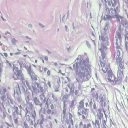

In [7]:
tf.keras.utils.load_img(benign_images[9], target_size=(size,size,1))

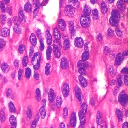

In [8]:
tf.keras.utils.load_img(malignant_images[45], target_size=(size,size,1))


In [9]:
# Checking the number of images
total_images = len(benign_images) + len(malignant_images)
total_images

7909

In [10]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(128, 128))  # Resize as needed
    img_array = tf.keras.utils.img_to_array(img)
    img_array /= 255.0  # Normalize the image
    return img_array

# Number of images to display
num_images_to_display = 8



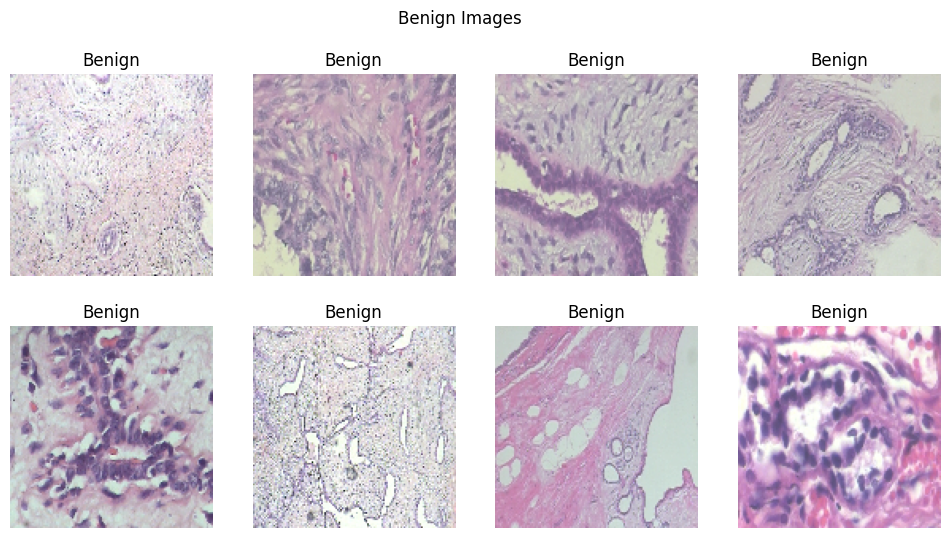

In [11]:
# Plot benign images
plt.figure(figsize=(12, 6))
for i in range(min(num_images_to_display, len(benign_images))):
    plt.subplot(2, 4, i + 1)
    img = load_and_preprocess_image(benign_images[i])
    plt.imshow(img)
    plt.title('Benign')
    plt.axis('off')

plt.suptitle('Benign Images')
plt.show()

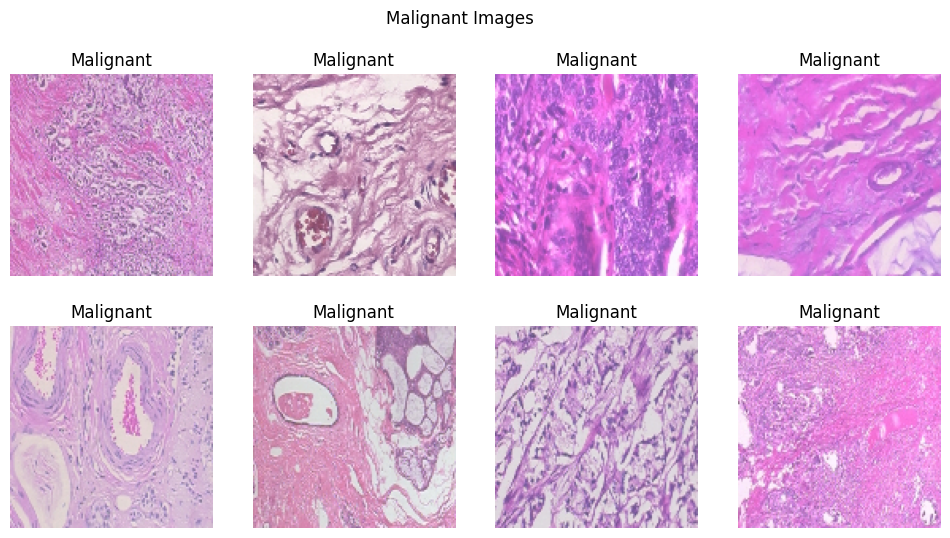

In [12]:
# Plot malignant images
plt.figure(figsize=(12, 6))
for i in range(min(num_images_to_display, len(malignant_images))):
    plt.subplot(2, 4, i + 1)
    img = load_and_preprocess_image(malignant_images[i])
    plt.imshow(img)
    plt.title('Malignant')
    plt.axis('off')

plt.suptitle('Malignant Images')
plt.show()


### 2.2 Creating the DataFrame

In [13]:
data = pd.DataFrame(index=np.arange(0, len(benign_images)+len(malignant_images)), columns=["image", "target"])
k=0
for c in [0,1]:
        if c==1:
            for m in range(len(benign_images)):
                data.iloc[k]["image"] = benign_images[m]
                data.iloc[k]["target"] = 0
                k += 1
        else:
            for m in range(len(malignant_images)):
                data.iloc[k]["image"] = malignant_images[m]
                data.iloc[k]["target"] = 1
                k += 1
print(data.shape)
print(data.head())

(7909, 2)
                                               image target
0  ./augmented/malignant/SOB_M_DC-14-11951-40-007...      1
1  ./augmented/malignant/SOB_M_PC-14-15704-200-00...      1
2  ./augmented/malignant/SOB_M_DC-14-5694-200-010...      1
3  ./augmented/malignant/SOB_M_MC-14-18842-200-01...      1
4  ./augmented/malignant/SOB_M_DC-14-17901-100-00...      1


In [14]:
count_data = data["target"].value_counts()
count_data

target
1    5429
0    2480
Name: count, dtype: int64

In [15]:
# Resampling the bengin data to balance the data
ben_upsampled= resample(data[data['target']==0], n_samples= data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

target
1    5429
0    5429
Name: count, dtype: int64

### 2.3) Splitting the data

In [16]:
kf= KFold(n_splits=10, random_state=42, shuffle= True)
kf

KFold(n_splits=10, random_state=42, shuffle=True)

In [17]:
train_image = []
y = []

# Loop over the up_sampled data to load images
for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size, size, 1))
    img = tf.keras.utils.img_to_array(img)
    img = img / 255  # Normalize the image
    train_image.append(img)
    y.append(up_sampled.iloc[i, -1])  # Append the corresponding label

# Convert lists to numpy arrays after the loop
X = np.array(train_image)
y = np.array(y)

# Now you can perform K-Fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    for train_index, test_index in kf.split(X_test, y_test):
        X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], y_test[train_index], y_test[test_index]

# Convert labels to categorical
Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

# Print shapes
print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)


100%|██████████| 10858/10858 [02:18<00:00, 78.32it/s]


(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


### 2.4) Image Augmentation 

In [18]:
my_input= Input(shape=(size, size, 3))
img_shape=(size, size,3)

In [19]:
data_gen= ImageDataGenerator(
        zoom_range=1.2,  # set range for random zoom
        rotation_range = 90,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

In [20]:
data_gen.fit(X_train)
X_train.shape[0]

9773

In [21]:
data_gen.fit(X_val)
X_val.shape[0]

108

In [22]:
data_gen.fit(X2_test)
X2_test.shape[0]

977

---
---
---

# **3) Model**

## **3.1) Hybrid algorithms**
### ( EfficientNet "Bottle neck" section, a CNN-based "neck" section,vision transformer)

In [24]:
# Distributed training for speeding up training times
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [25]:
# bottleneck 
def bottleneck0(inputs):
    backbone= tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top= False)
    x= backbone(inputs)
    x= GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x= Dense(256, activation='relu')(x)
    x= Flatten()(x)
    return x

In [26]:
# neck
def neck_section(inputs):
    x= Conv2D(256, (7,7), strides=(2,2), padding='same')(inputs)
    x= BatchNormalization()(x)
    x= PReLU()(x)
    x= MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x= Flatten()(x)
    return x

In [27]:
# Vision Transform Section
def vision_transform(inputs, patch_size):
    
    # Reshape input into patches
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: K.cast(image, 'float32') / 255.0)(x)

    # architecture for each patch processing
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output
    x = Flatten()(x)
    
    return x


In [28]:
# overall model incorporating patches in the vision transform section and the neck section
def model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)
    
    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)

    # Merging the bottleneck, patches transform, and neck sections
    merged = tf.keras.layers.concatenate([efficientnet_bottleneck, patches_transform, neck])
    
    outputs = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
input_shape = (size, size, 3)  
num_classes = 2  
patch_size = (32, 32)   # Size of the image patches
batch_size = 64

In [30]:
with strategy.scope():
    model = model(input_shape, num_classes, patch_size)
    model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                metrics = (['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='AUC')]))

print(model.input_shape)
print(model.output_shape)
model.summary()  

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 128, 128, 3)
(None, 2)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 32,    │          0 │ input_layer_1[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32,    │          0 │ reshape[0][0]     │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │     27,712 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 4, 4,      │  5,919,312 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     37,888 │ input_layer_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 64, 64,    │  1,048,576 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 8,157,138 (31.12 MB)

 Trainable params: 8,093,458 (30.87 MB)

 Non-trainable params: 63,680 (248.75 KB)

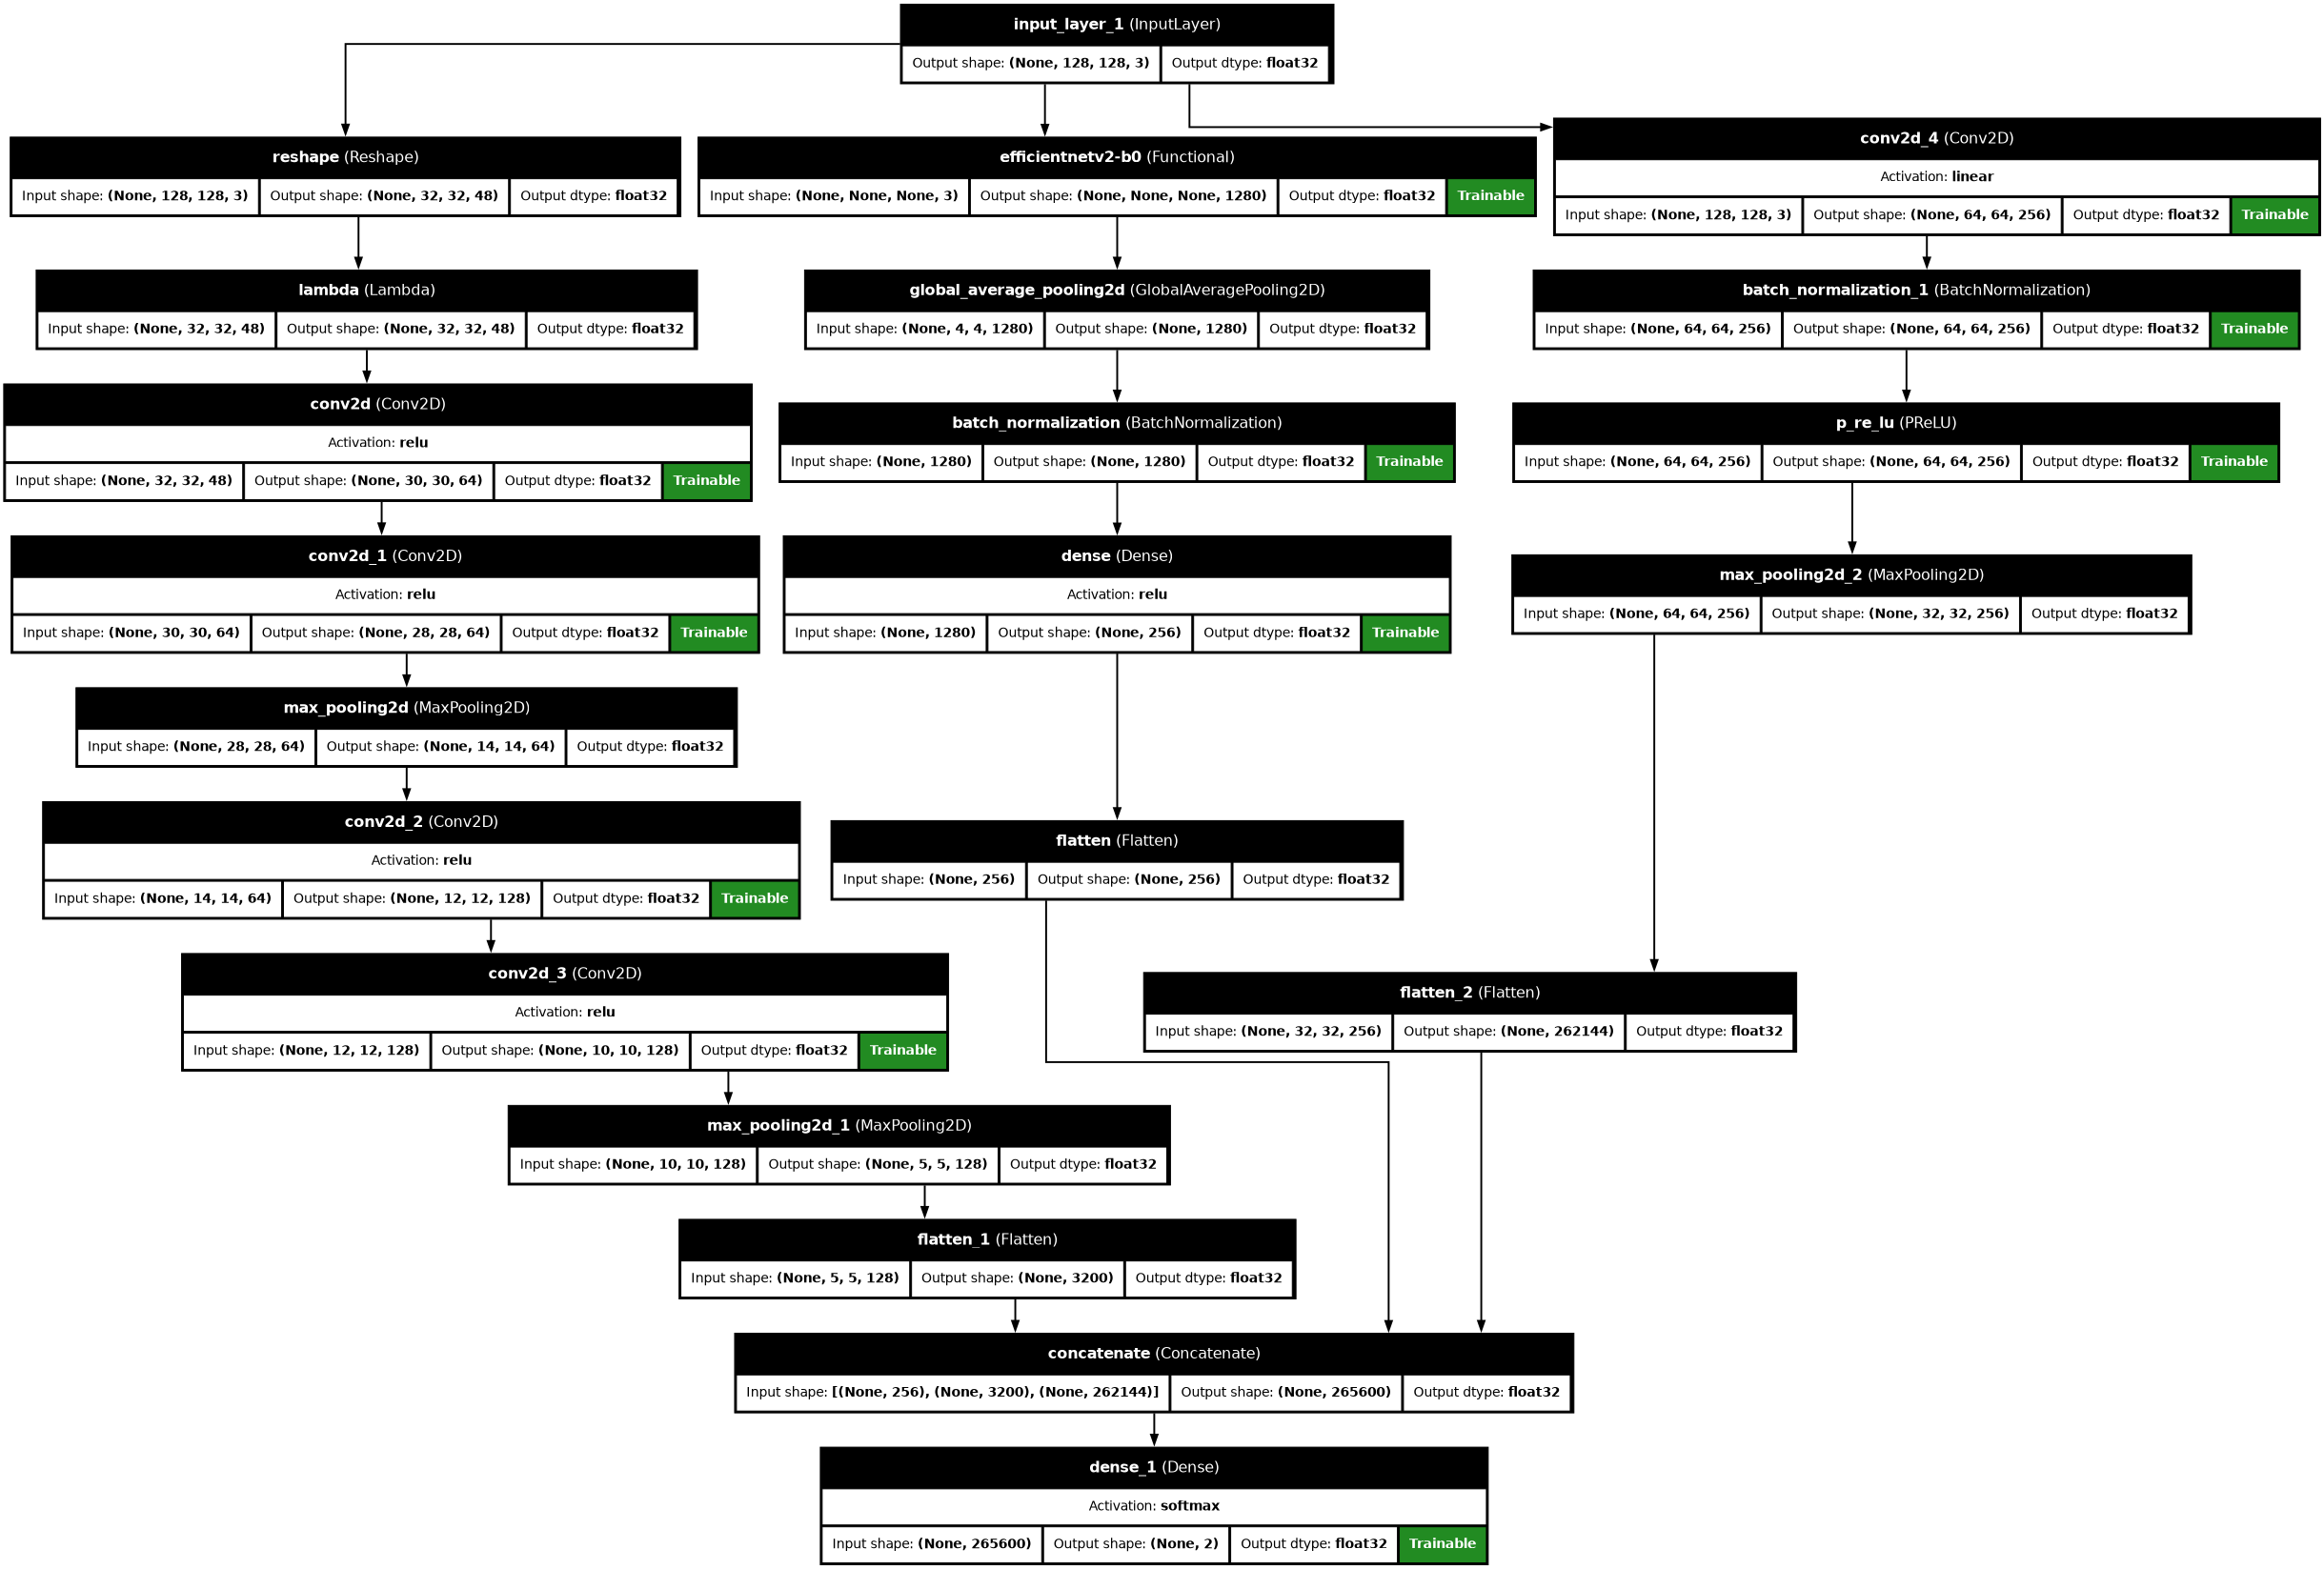

In [31]:
tf.keras.utils.plot_model(model, 
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
            show_trainable= True,
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [24]:
# Callback functions for training
epochs = 50

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = tf.keras.callbacks.CSVLogger('Model.log')


callbacks = [earlystop, csv_logger, reduce_lr]

In [33]:
%%time
history = model.fit(data_gen.flow(X_train,Y_train,
                                       batch_size = batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks = callbacks,
                    epochs=50,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    validation_data =(data_gen.flow(X_val,Y_val,
                                       batch_size = batch_size, 
                                       seed=27,
                                       shuffle=True)))

Epoch 1/50


2024-10-27 21:20:26.297320: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_1914/cond/StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


152/152 ━━━━━━━━━━━━━━━━━━━━ 241s 437ms/step - AUC: 0.6799 - accuracy: 0.6658 - loss: 13.7239 - precision: 0.6658 - recall: 0.6658 - val_AUC: 0.7925 - val_accuracy: 0.7593 - val_loss: 1.0880 - val_precision: 0.7593 - val_recall: 0.7593 - learning_rate: 0.0010
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8828 - accuracy: 0.8741 - loss: 4.7870 - precision: 0.8741 - recall: 0.8741 - val_AUC: 0.7534 - val_accuracy: 0.7037 - val_loss: 1.2062 - val_precision: 0.7037 - val_recall: 0.7037 - learning_rate: 0.0010
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 60s 378ms/step - AUC: 0.7325 - accuracy: 0.7123 - loss: 6.2737 - precision: 0.7123 - recall: 0.7123 - val_AUC: 0.4630 - val_accuracy: 0.4630 - val_loss: 11.4675 - val_precision: 0.4630 - val_recall: 0.4630 - learning_rate: 0.0010
Epoch 6/50
  1/152 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - AUC: 0.6841 - accuracy: 0.6406 - loss: 4.0686 - precision: 0.6406 - recall: 0.6406
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000200000

In [34]:
# Saving the model
model.save("modelBH.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
# Saving the metrics of all the epochs and display it
df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
df.head(50)

AUC  accuracy       loss  precision    recall   val_AUC  \
0   0.692453  0.676210  10.822117   0.676210  0.676210  0.792524   
1   0.883789  0.875000   4.767801   0.875000  0.875000  0.753429   
2   0.732579  0.712873   6.027740   0.712873  0.712873  0.726680   
3   0.756836  0.750000   7.103559   0.750000  0.750000  0.568930   
4   0.721413  0.700103   6.618655   0.700103  0.700103  0.462963   
5   0.791016  0.718750   1.787447   0.718750  0.718750  0.375171   
6   0.785823  0.732235   1.872003   0.732235  0.732235  0.431070   
7   0.810547  0.812500   1.557052   0.812500  0.812500  0.555556   
8   0.790928  0.731823   1.472371   0.731823  0.731823  0.758230   
9   0.836914  0.812500   1.390228   0.812500  0.812500  0.784979   
10  0.804391  0.742739   1.156964   0.742739  0.742739  0.580933   
11  0.950195  0.875000   0.312073   0.875000  0.875000  0.630144   
12  0.835476  0.759423   0.697492   0.759423  0.759423  0.695473   
13  0.913086  0.781250   0.362819   0.781250  0.781250  0.691015   
14  0.837885  0.755510   0.667021   0.755510  0.755510  0.802469   
15  0.781250  0.656250   0.768206   0.656250  0.656250  0.748285   
16  0.837823  0.764573   0.647535   0.764573  0.764573  0.766118   
17  0.906250  0.843750   0.398703   0.843750  0.843750  0.780864   
18  0.846837  0.773635   0.615710   0.773635  0.773635  0.786694   
19  0.820312  0.750000   0.619987   0.750000  0.750000  0.664095   
20  0.844372  0.770134   0.605763   0.770134  0.770134  0.811043   
21  0.810547  0.750000   0.623072   0.750000  0.750000  0.715364   
22  0.855742  0.776107   0.568550   0.776107  0.776107  0.891632   
23  0.779297  0.687500   0.883569   0.687500  0.687500  0.783608   
24  0.866107  0.780227   0.525424   0.780227  0.780227  0.689300   
25  0.765625  0.750000   1.105929   0.750000  0.750000  0.645405   
26  0.865277  0.787848   0.528779   0.787848  0.787848  0.795267   
27  0.778320  0.718750   0.979197   0.718750  0.718750  0.877915   
28  0.860428  0.775077   0.517078   0.775077  0.775077  0.834362   
29  0.887695  0.750000   0.405415   0.750000  0.750000  0.812414   
30  0.870292  0.788671   0.484752   0.788671  0.788671  0.874143   
31  0.868164  0.718750   0.446068   0.718750  0.718750  0.829218   
32  0.887088  0.805149   0.450440   0.805149  0.805149  0.821159   
33  0.854980  0.781250   0.504354   0.781250  0.781250  0.797325   
34  0.883120  0.800824   0.452713   0.800824  0.800824  0.880144   
35  0.938477  0.906250   0.313404   0.906250  0.906250  0.813443   
36  0.881930  0.801648   0.448853   0.801648  0.801648  0.865226   
37  0.942383  0.812500   0.296383   0.812500  0.812500  0.776749   
38  0.885536  0.807003   0.443159   0.807003  0.807003  0.824417   
39  0.891602  0.843750   0.428759   0.843750  0.843750  0.883573   
40  0.884079  0.797116   0.445281   0.797116  0.797116  0.883059   
41  0.911133  0.875000   0.392584   0.875000  0.875000  0.836420   
42  0.884089  0.807209   0.445510   0.807209  0.807209  0.936214   
43  0.829102  0.750000   0.553403   0.750000  0.750000  0.815501   
44  0.887281  0.802266   0.436633   0.802266  0.802266  0.816872   
45  0.916992  0.781250   0.362634   0.781250  0.781250  0.861111   
46  0.894200  0.809475   0.421438   0.809475  0.809475  0.876543   
47  0.859375  0.718750   0.460050   0.718750  0.718750  0.884602   
48  0.888022  0.808857   0.437754   0.808857  0.808857  0.876372   
49  0.888672  0.843750   0.470273   0.843750  0.843750  0.826132   

    val_accuracy   val_loss  val_precision  val_recall  learning_rate  
0       0.759259   1.087979       0.759259    0.759259   1.000000e-03  
1       0.703704   1.206241       0.703704    0.703704   1.000000e-03  
2       0.722222   2.339581       0.722222    0.722222   1.000000e-03  
3       0.537037  11.087135       0.537037    0.537037   1.000000e-03  
4       0.462963  11.467462       0.462963    0.462963   1.000000e-03  
5       0.425926   7.477747       0.425926    0.425926   1.000000e-03  
6       0.425926  10.589593       0.

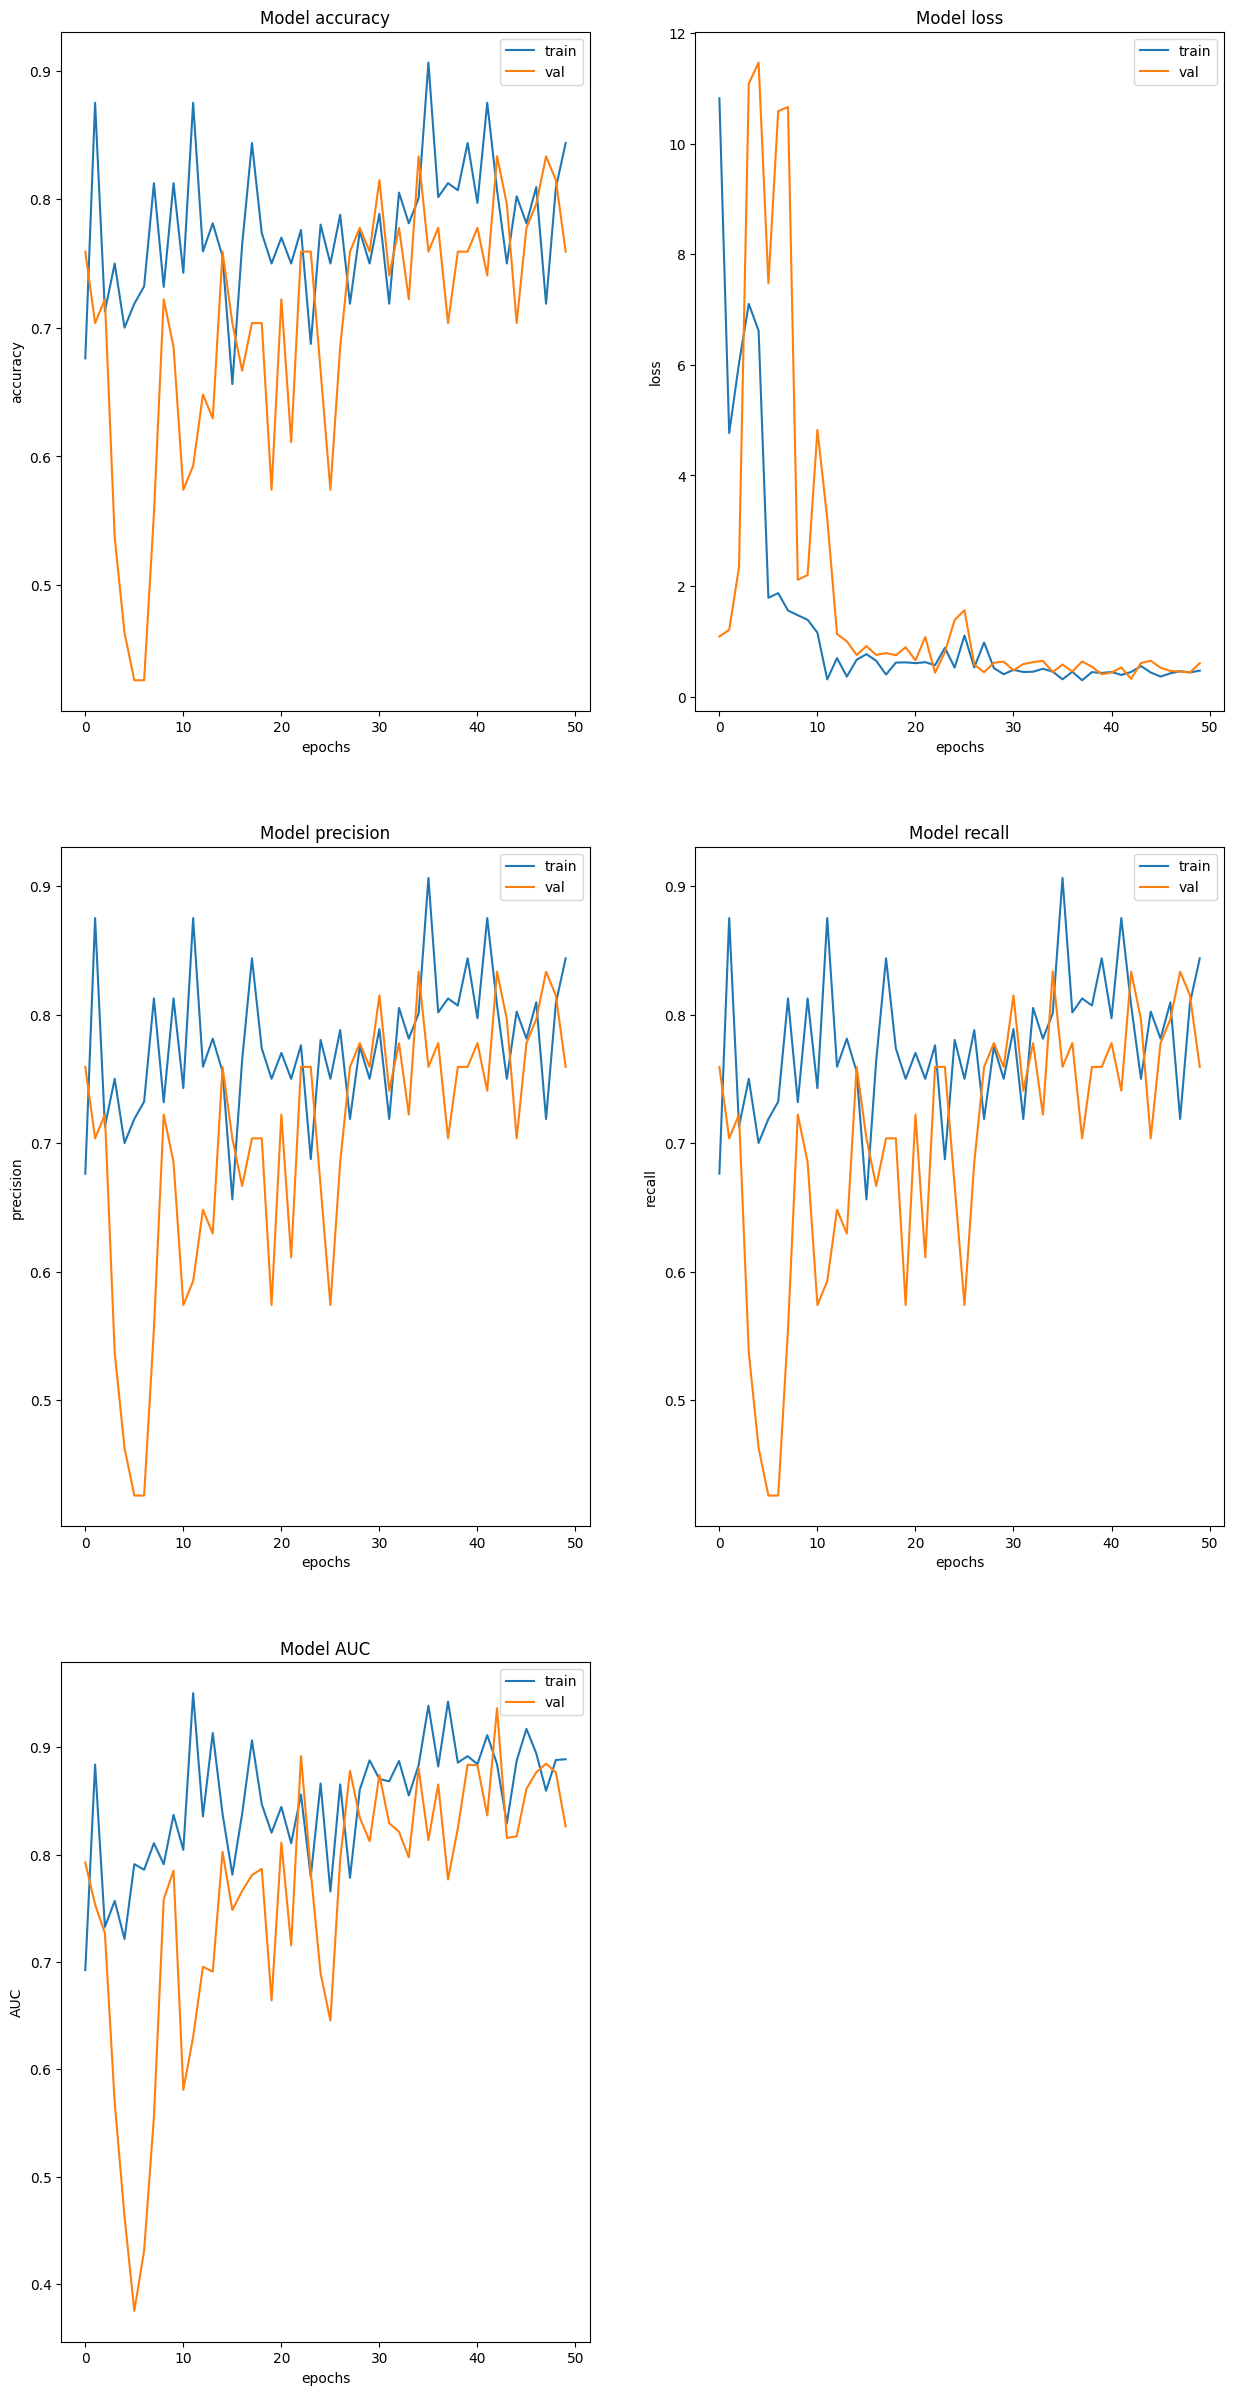

In [36]:
# Interpreting the Metrics
fig, ax = plt.subplots(3, 2, figsize=(15, 30))  # Adjusted to 3x2 grid to fit 5 plots
ax = ax.ravel()

metrics = ['accuracy', 'loss', 'precision', 'recall', 'AUC']  # Only five metrics
for i, met in enumerate(metrics):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

ax[-1].axis('off')  # Turns off the empty subplot

plt.savefig("Model-Results.png")
plt.show()


### Model evaluation on test partition


In [37]:
Test_data =(data_gen.flow(X2_test,Y_test,
                                       batch_size=128, 
                                       seed=27,
                                       shuffle=True))

In [38]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(Test_data, batch_size=32, callbacks= callbacks)
print("test loss test acc:", results)

Evaluate on test data
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step - AUC: 0.8723 - accuracy: 0.7908 - loss: 0.4793 - precision: 0.7908 - recall: 0.7908
test loss test acc: [0.4345066547393799, 0.8179959058761597, 0.8179959058761597, 0.8179959058761597, 0.8882134556770325]
CPU times: user 10.9 s, sys: 156 ms, total: 11 s
Wall time: 6.91 s


In [39]:
# Calculate predictions
x = X2_test
y = Y_test

yhat = model.predict(x)

# Extract class predictions
predy = np.argmax(yhat, axis=1)
truey = np.argmax(y, axis=1)

# Calculate accuracy
acc = (np.sum(predy == truey) / len(y)) * 100

# Saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)

print("Predicted and true label values saved")
print(f"Accuracy on test set: {acc}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 267ms/step
Predicted and true label values saved
Accuracy on test set: 78.9150460593654%


In [40]:
def confusion_matrix_img(y_pred, y_true, savename):
    # Generate confusion matrix from true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']  # Define class labels for display
    title = 'Confusion matrix'
    print(cm)  # Output the confusion matrix to the console for reference

    # Plot confusion matrix as an image with a blue color map
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a color bar to indicate value scale
    
    # Set up tick marks and label them with class names
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)  # X-axis labels with rotation
    plt.yticks(tick_marks, labels)  # Y-axis labels
    
    # Define formatting for text annotations (integer format)
    fmt = 'd'
    # Threshold value to decide text color for better contrast
    thresh = cm.max() / 2.
    
    # Loop through matrix cells and add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Cell text based on matrix value
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Contrast text color
    
    # Add axis labels for clarity
    plt.ylabel('True label')  # Y-axis for actual labels
    plt.xlabel('Predicted label')  # X-axis for predicted labels
    
    # Adjust layout to fit elements within the plot area
    plt.tight_layout()
    
    # Save the plot as an image file with the specified name
    plt.savefig(savename)
    
    # Display the plot inline
    plt.show()


[[452 158]
 [ 48 319]]


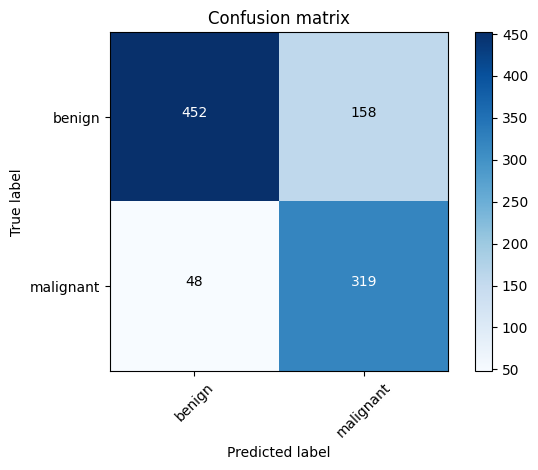

In [41]:
confusion_matrix_img(truey, predy, savename='Confusion Matrix')